## Forecasting in Pyro

In [15]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features

%matplotlib inline
pyro.set_rng_seed(20200305)

dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


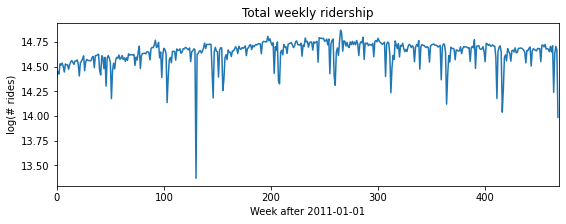

In [9]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

Let’s start with a simple log-linear regression model, with no trend or seasonality. Note that while this example is univariate, Pyro’s forecasting framework is multivariate, so we’ll often need to reshape using .unsqueeze(-1), .expand([1]), and .to_event(1).

In [10]:
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)

In [11]:
T0 = 0              # begining
T2 = data.size(-2)  # end
T1 = T2 - 52        # train/test split

In [23]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 484401
INFO 	 step  100 loss = 0.609515
INFO 	 step  200 loss = -0.574004
INFO 	 step  300 loss = -0.592534
INFO 	 step  400 loss = -0.605461
INFO 	 step  500 loss = -0.597935
INFO 	 step  600 loss = -0.605653
INFO 	 step  700 loss = -0.612012
INFO 	 step  800 loss = -0.609876
INFO 	 step  900 loss = -0.613109
INFO 	 step 1000 loss = -0.606249


CPU times: user 4.62 s, sys: 30.9 ms, total: 4.65 s
Wall time: 4.69 s


Next we can evaluate by drawing posterior samples from the forecaster, passing in full covariates but only partial data. We’ll use Pyro’s quantile() function to plot median and an 80% confidence interval. To evaluate fit we’ll use eval_crps() to compute Continuous Ranked Probability Score; this is an good metric to assess distributional fit of a heavy-tailed distribution.

torch.Size([1000, 52, 1]) torch.Size([52])


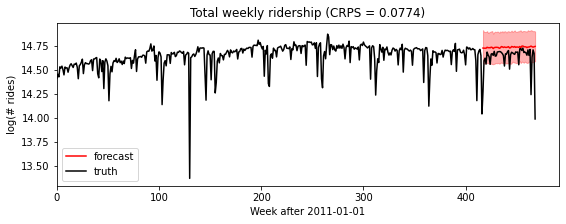

In [13]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

We could add a yearly seasonal component simply by adding new covariates (note we’ve already taken care in the model to handle feature_dim > 1).

In [33]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 7)], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 53174.4
INFO 	 step  100 loss = 0.526435
INFO 	 step  200 loss = -0.0154417
INFO 	 step  300 loss = -0.28896
INFO 	 step  400 loss = -0.311957
INFO 	 step  500 loss = -0.457713
INFO 	 step  600 loss = -0.456495
INFO 	 step  700 loss = -0.548652
INFO 	 step  800 loss = -0.520295
INFO 	 step  900 loss = -0.568069
INFO 	 step 1000 loss = -0.594111


CPU times: user 4.51 s, sys: 27.8 ms, total: 4.54 s
Wall time: 4.55 s


In [39]:
periodic_features(T2, 365.25 / 7)

469

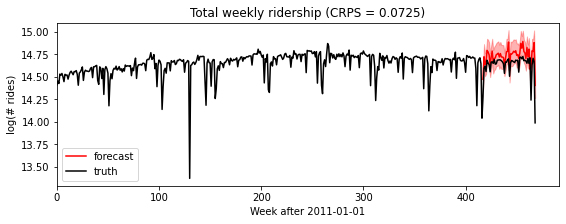

In [17]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

In [18]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [56]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct",
                       )

/Users/jonny/opt/miniconda3/envs/deeplearn/lib/python3.6/site-packages/pyro/poutine/reparam_messenger.py:116: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  RuntimeWarning,
INFO 	 step    0 loss = 1.73259e+09
INFO 	 step  100 loss = 1.09182
INFO 	 step  200 loss = -0.0402735
INFO 	 step  300 loss = -0.156852
INFO 	 step  400 loss = -0.243867
INFO 	 step  500 loss = -0.371154
INFO 	 step  600 loss = -0.334386
INFO 	 step  700 loss = -0.43255
INFO 	 step  800 loss = -0.450773
INFO 	 step  900 loss = -0.484612
INFO 	 step 1000 loss = -0.520161


CPU times: user 8.75 s, sys: 35.6 ms, total: 8.78 s
Wall time: 8.79 s


In [57]:
for p in forecaster.named_parameters():
    print(p)

('guide.locs.bias_unconstrained', Parameter containing:
tensor([14.6411], requires_grad=True))
('guide.locs.weight_unconstrained', Parameter containing:
tensor([-0.0266, -0.0439, -0.0070, -0.0197, -0.0118, -0.0306, -0.0112, -0.0366,
        -0.0303, -0.0277,  0.0376,  0.0002,  0.0315,  0.0109,  0.0023, -0.0033,
         0.0081, -0.0120,  0.0249,  0.0256,  0.0365,  0.0063,  0.0179,  0.0028,
         0.0001,  0.0028,  0.0182, -0.0110, -0.0207, -0.0052,  0.0032,  0.0003,
        -0.0036, -0.0059, -0.0183, -0.0302, -0.0199, -0.0327, -0.0243, -0.0132,
        -0.0046, -0.0093, -0.0041, -0.0048, -0.0062, -0.0168,  0.0007, -0.0093,
         0.0238,  0.0074,  0.0163,  0.0046], requires_grad=True))
('guide.locs.drift_scale_unconstrained', Parameter containing:
tensor([-10.8745], requires_grad=True))
('guide.locs.drift_decentered_haar_unconstrained', Parameter containing:
tensor([[[ 4.8016e-02],
         [-4.5886e-02],
         [-1.8467e-02],
         [ 5.8030e-02],
         [ 8.7982e-02],
     

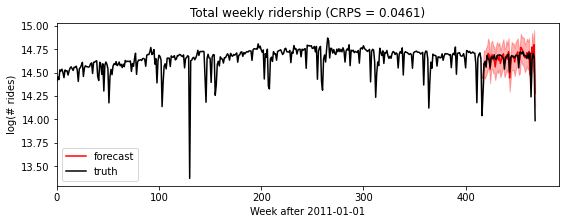

In [20]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

## Hierarchical Forecasting in Pyro

From this tutorial: https://pyro.ai/examples/forecasting_iii.html

In [4]:
dataset

{'stations': ['12TH',
  '16TH',
  '19TH',
  '24TH',
  'ANTC',
  'ASHB',
  'BALB',
  'BAYF',
  'BERY',
  'CAST',
  'CIVC',
  'COLM',
  'COLS',
  'CONC',
  'DALY',
  'DBRK',
  'DELN',
  'DUBL',
  'EMBR',
  'FRMT',
  'FTVL',
  'GLEN',
  'HAYW',
  'LAFY',
  'LAKE',
  'MCAR',
  'MLBR',
  'MLPT',
  'MONT',
  'NBRK',
  'NCON',
  'OAKL',
  'ORIN',
  'PCTR',
  'PHIL',
  'PITT',
  'PLZA',
  'POWL',
  'RICH',
  'ROCK',
  'SANL',
  'SBRN',
  'SFIA',
  'SHAY',
  'SSAN',
  'UCTY',
  'WARM',
  'WCRK',
  'WDUB',
  'WOAK'],
 'start_date': (datetime.datetime(2011, 1, 1, 0, 0),),
 'counts': tensor([[[ 1.,  1.,  0.,  ...,  1.,  0.,  3.],
          [ 5.,  0.,  8.,  ...,  0.,  0.,  6.],
          [ 1.,  4.,  1.,  ...,  0.,  0.,  2.],
          ...,
          [ 0.,  3.,  1.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 1.,  4.,  0.,  ...,  0.,  0.,  2.]],
 
         [[ 0.,  6.,  0.,  ...,  5.,  0.,  6.],
          [19.,  3., 14.,  ...,  8.,  0., 38.],
          [ 3., 21.,

torch.Size([78888, 50])


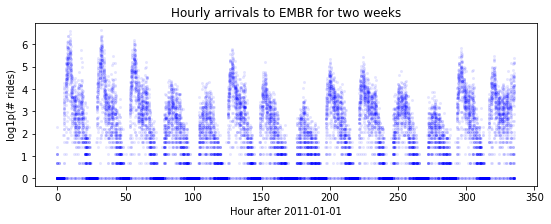

In [5]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:, :, dataset["stations"].index("EMBR")].log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data[-24 * 7 * 2:], 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Hourly arrivals to EMBR for two weeks")
plt.ylabel("log1p(# rides)")
plt.xlabel("Hour after 2011-01-01");

In [6]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.shape

        # Let's model each time series as a Levy stable process, and share process parameters
        # across time series. To do that in Pyro, we'll declare the shared random variables
        # outside of the "origin" plate:
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with pyro.plate("origin", data_dim, dim=-2):
            # Now inside of the origin plate we sample drift and seasonal components.
            # All the time series inside the "origin" plate are independent,
            # given the drift parameters above.
            with self.time_plate:
                # We combine two different reparameterizers: the inner SymmetricStableReparam
                # is needed for the Stable site, and the outer LocScaleReparam is optional but
                # appears to improve inference.
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))

            with pyro.plate("hour_of_week", 24 * 7, dim=-1):
                seasonal = pyro.sample("seasonal", dist.Normal(0, 5))

        # Now outside of the time plate we can perform time-dependent operations like
        # integrating over time. This allows us to create a motion with slow drift.
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        prediction = motion + seasonal

        # Next we do some reshaping. Pyro's forecasting framework assumes all data is
        # multivariate of shape (duration, data_dim), but the above code uses an "origins"
        # plate that is left of the time_plate. Our prediction starts off with shape
        assert prediction.shape[-2:] == (data_dim, duration)
        # We need to swap those dimensions but keep the -2 dimension intact, in case Pyro
        # adds sample dimensions to the left of that.
        prediction = prediction.unsqueeze(-1).transpose(-1, -3)
        assert prediction.shape[-3:] == (1, duration, data_dim), prediction.shape

        # Finally we can construct a noise distribution.
        # We will share parameters across all time series.
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-5, 5))
        noise_dist = dist.Normal(0, obs_scale.unsqueeze(-1))
        self.predict(noise_dist, prediction)